# Notebook 01: Data Audit, Integrity Checks, and Baseline Model

---

## 1. Introduction and Research Context

This notebook analyzes the Nashville Police Department traffic stop dataset to investigate potential racial bias in arrest outcomes. Our research question is:

> **Can we predict whether a traffic stop results in an arrest, and do prediction patterns reveal demographic disparities?**

**Target Variable:** `arrest_made` (binary: True/False)

**Approach:** We follow a systematic data science workflow:
1. Initial data exploration without assumptions
2. Evidence-based dtype optimization decisions
3. Rigorous integrity and consistency checks
4. Leakage detection to ensure valid modeling
5. Baseline model establishment

---

## 2. Environment Setup and Reproducibility

**Rationale:** Scientific reproducibility requires fixed random seeds and documented package versions. We set `SEED=42` (a common convention) and capture all library versions for future replication.

In [1]:
import os
import random
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.calibration import calibration_curve

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
warnings.filterwarnings('ignore')

# Document environment
print("=" * 50)
print("ENVIRONMENT CONFIGURATION")
print("=" * 50)
print(f"Execution Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Random Seed: {SEED}")
print(f"Python: {os.sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
import sklearn; print(f"Scikit-learn: {sklearn.__version__}")

ENVIRONMENT CONFIGURATION
Execution Time: 2026-01-15 17:03:55
Random Seed: 42
Python: 3.10.19
Pandas: 2.3.3
NumPy: 2.2.6
Scikit-learn: 1.7.2


---

## 3. Initial Data Loading and First Impressions

**Approach:** Before making any optimization decisions, we must first understand what we're working with. We load a small sample to examine the raw data structure, then make informed decisions about memory optimization.

In [2]:
# First, load a small sample to understand the data structure
DATA_FILE = 'tn_nashville_2020_04_01.csv'

print(f"Loading sample from: {DATA_FILE}")
print(f"File size: {os.path.getsize(DATA_FILE) / 1024**2:.1f} MB")
print()

# Load only first 1000 rows to examine structure
df_sample = pd.read_csv(DATA_FILE, nrows=1000)

print(f"Sample shape: {df_sample.shape}")
print(f"Columns: {df_sample.shape[1]}")
print()

sample_mem_bytes = df_sample.memory_usage(deep=True).sum()
with open(DATA_FILE, 'rb') as f:
    sample_disk_bytes = sum(len(f.readline()) for _ in range(1001))
total_disk_bytes = os.path.getsize(DATA_FILE)
ratio = total_disk_bytes / sample_disk_bytes
estimated_total_mem_gb = (sample_mem_bytes * ratio) / (1024**3)
print(f"Estimated total memory: {estimated_total_mem_gb:.1f} GB")

Loading sample from: tn_nashville_2020_04_01.csv
File size: 992.9 MB

Sample shape: (1000, 42)
Columns: 42

Estimated total memory: 3.6 GB


### 3.1 Examining Raw Data Structure

**Question:** What does the data look like before any processing?

In [3]:
# View first few rows to understand content
print("First 3 rows (transposed for readability):")
print()
display(df_sample.head(3).T)

First 3 rows (transposed for readability):



,0,1,2
raw_row_number,232947,237161,232902
date,2010-10-10,2010-10-10,2010-10-10
time,NaN,10:00:00,10:00:00
location,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...","1122 LEBANON PIKE, NASHVILLE, TN, 37210","898 DAVIDSON DR, , TN, 37205"
lat,36.187925,36.155521,36.11742
lng,-86.798519,-86.735902,-86.895593
precinct,6.0,5.0,1.0
reporting_area,4403.0,9035.0,5005.0
zone,611.0,513.0,121.0
subject_age,27,18,52


In [4]:
# Examine pandas' auto-detected dtypes
print("Pandas auto-detected data types:")
print()
df_sample.info()

Pandas auto-detected data types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   raw_row_number                  1000 non-null   object 
 1   date                            1000 non-null   object 
 2   time                            996 non-null    object 
 3   location                        1000 non-null   object 
 4   lat                             969 non-null    float64
 5   lng                             969 non-null    float64
 6   precinct                        852 non-null    float64
 7   reporting_area                  863 non-null    float64
 8   zone                            852 non-null    float64
 9   subject_age                     1000 non-null   int64  
 10  subject_race                    1000 non-null   object 
 11  subject_sex                     999 non-null    object 
 12  o

In [5]:
# Descriptive statistics for all columns
print("Descriptive statistics (all columns):")
display(df_sample.describe(include='all').T)

Descriptive statistics (all columns):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
raw_row_number,1000,1000,615781,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,1000,2,2010-10-10,665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,996,621,10:48:00,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,1000,684,"BABY RUTH LN & MOUNT VIEW RD, ANTIOCH, TN, 37013",15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,969.0,NaN,NaN,NaN,36.146139,0.086319,35.199884,36.107112,36.15222,36.183781,36.427898
lng,969.0,NaN,NaN,NaN,-86.75235,0.127847,-87.029436,-86.800243,-86.757262,-86.708781,-84.24684
precinct,852.0,NaN,NaN,NaN,4.875587,2.458304,1.0,3.0,5.0,7.0,8.0
reporting_area,863.0,NaN,NaN,NaN,7700.633835,11877.546004,1101.0,4106.0,5815.0,8709.0,94022.0
zone,852.0,NaN,NaN,NaN,508.058685,247.343149,111.0,315.0,521.0,727.0,835.0
subject_age,1000.0,NaN,NaN,NaN,36.148,14.761029,16.0,24.0,32.0,46.0,99.0


---

## 4. Evidence-Based Memory Optimization

**Problem:** The full dataset is ~1GB. Loading with default dtypes will consume excessive RAM.

**Solution:** Based on our sample analysis, we create an optimized dtype map. Each decision is justified by evidence from the data.

### 4.1 Analyzing Each Column for Optimization

In [6]:
# Analyze each column to determine optimal dtype
print("COLUMN-BY-COLUMN ANALYSIS FOR DTYPE OPTIMIZATION")
print("=" * 60)

for col in df_sample.columns:
    current_dtype = df_sample[col].dtype
    non_null = df_sample[col].notna().sum()
    unique_vals = df_sample[col].nunique()
    sample_vals = df_sample[col].dropna().head(3).tolist()
    
    print(f"\n{col}:")
    print(f"  Current dtype: {current_dtype}")
    print(f"  Non-null: {non_null}/1000")
    print(f"  Unique values: {unique_vals}")
    print(f"  Sample: {sample_vals[:3]}")

COLUMN-BY-COLUMN ANALYSIS FOR DTYPE OPTIMIZATION

raw_row_number:
  Current dtype: object
  Non-null: 1000/1000
  Unique values: 1000
  Sample: ['232947', '237161', '232902']

date:
  Current dtype: object
  Non-null: 1000/1000
  Unique values: 2
  Sample: ['2010-10-10', '2010-10-10', '2010-10-10']

time:
  Current dtype: object
  Non-null: 996/1000
  Unique values: 621
  Sample: ['10:00:00', '10:00:00', '22:00:00']

location:
  Current dtype: object
  Non-null: 1000/1000
  Unique values: 684
  Sample: ['DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, TN, 37208', '1122 LEBANON PIKE, NASHVILLE, TN, 37210', '898 DAVIDSON DR, , TN, 37205']

lat:
  Current dtype: float64
  Non-null: 969/1000
  Unique values: 635
  Sample: [36.1879249, 36.155521, 36.1174196]

lng:
  Current dtype: float64
  Non-null: 969/1000
  Unique values: 635
  Sample: [-86.7985195, -86.73590200000002, -86.8955929]

precinct:
  Current dtype: float64
  Non-null: 852/1000
  Unique values: 8
  Sample: [6.0, 5.0, 1.0]

report

### 4.2 Dtype Optimization Decisions

Based on the analysis above, here are the optimization decisions with justifications:

| Column | Original | Optimized | Justification |
|--------|----------|-----------|---------------|
| `date` | object | string | ISO date format (YYYY-MM-DD), parse later to datetime |
| `time` | object | string | Time string (HH:MM:SS), parse later |
| `precinct`, `zone` | float64 | float32 | Integer codes with NaN; float32 handles both |
| `subject_age` | int64 | Int16 | May have NaN; Int16 sufficient for age 0-120 |
| `subject_race`, `subject_sex` | object | category | Low cardinality (5, 2 unique values) |
| `arrest_made`, etc. | bool | boolean | Already boolean, but use nullable boolean |
| `contraband_*` | object | boolean | True, False, and NaN natively |

In [7]:
# Create optimized dtype map based on our analysis
DTYPE_MAP = {
    # Identifiers and text
    'raw_row_number': 'string',
    'location': 'string',
    'officer_id_hash': 'string',
    'notes': 'string',
    
    # Temporal - keep as string, parse later
    'date': 'string',
    'time': 'string',
    
    # GPS coordinates
    'lat': 'float64',
    'lng': 'float64',

    # Numeric - downcast to float32
    'precinct': 'float32',
    'reporting_area': 'float32',
    'zone': 'float32',
    'subject_age': 'Int16',
    
    # Low-cardinality categorical
    'subject_race': 'category',
    'subject_sex': 'category',
    'type': 'category',
    'outcome': 'category',
    'vehicle_registration_state': 'category',
    'raw_suspect_ethnicity': 'category',
    
    # Text fields that need parsing
    'violation': 'string',
    'reason_for_stop': 'string',
    'search_basis': 'string',
    
    # Boolean fields - some stored as object
    'arrest_made': 'boolean',
    'citation_issued': 'boolean',
    'warning_issued': 'boolean',
    'frisk_performed': 'boolean',
    'search_conducted': 'boolean',
    'search_person': 'boolean',
    'search_vehicle': 'boolean',
    
    # Contraband - stored as boolean True/False/NaN
    'contraband_found': 'boolean',
    'contraband_drugs': 'boolean',
    'contraband_weapons': 'boolean',
    
    # Raw boolean flags
    'raw_verbal_warning_issued': 'boolean',
    'raw_written_warning_issued': 'boolean',
    'raw_traffic_citation_issued': 'boolean',
    'raw_misd_state_citation_issued': 'boolean',
    'raw_driver_searched': 'boolean',
    'raw_passenger_searched': 'boolean',
    'raw_search_consent': 'boolean',
    'raw_search_arrest': 'boolean',
    'raw_search_warrant': 'boolean',
    'raw_search_inventory': 'boolean',
    'raw_search_plain_view': 'boolean',
}

print(f"Defined dtype map for {len(DTYPE_MAP)} columns")

Defined dtype map for 42 columns


### 4.3 Loading Full Dataset

In [8]:
# Modified DTYPE_MAP: Load numeric targets as strings first to handle garbage
DTYPE_MAP_SAFE = DTYPE_MAP.copy()

# List of columns that are likely dirty (containing 'U', '?', etc.)
risky_numeric_cols = [
    'lat', 'lng', 
    'precinct', 'reporting_area', 'zone', 
    'subject_age'
]

# Temporarily map them to string (or object) to allow safe loading
for col in risky_numeric_cols:
    DTYPE_MAP_SAFE[col] = 'string' # allows 'U' to load

# Load full dataset with optimized dtypes
print("Loading dataset with safe types...")

# 1. Load with relaxed types
try:
    df = pd.read_csv(DATA_FILE, dtype=DTYPE_MAP_SAFE, low_memory=False)
except MemoryError:
    # Fallback for low memory
    chunks = []
    for chunk in pd.read_csv(DATA_FILE, dtype=DTYPE_MAP_SAFE, chunksize=200000):
        chunks.append(chunk)
    df = pd.concat(chunks, ignore_index=True)

print(f"Loaded {len(df):,} rows. Starting numeric coercion...")

# 2. Safe Coercion
# This converts 'U', '', 'Unknown' to NaN (Not a Number)
for col in risky_numeric_cols:
    # coerce errors turn 'U' into NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Optimize Dtypes (Now that garbage is gone)
# We can safely downcast now
numeric_optimizations = {
    'lat': 'float64',
    'lng': 'float64',
    'precinct': 'float32',
    'reporting_area': 'float32',
    'zone': 'float32',
    'subject_age': 'Int16'
}

for col, dtype in numeric_optimizations.items():
    df[col] = df[col].astype(dtype)

print("Conversion complete.")
print("-" * 30)

# Final Memory Report
mem_mb = df.memory_usage(deep=True).sum() / 1024**2
print(f"Final Memory usage: {mem_mb:.1f} MB")

Loading dataset with safe types...
Loaded 3,092,351 rows. Starting numeric coercion...
Conversion complete.
------------------------------
Final Memory usage: 2127.8 MB


---

## 5. Dataset Profiling

Now that we have the full data loaded, let's create a comprehensive profile.

### 5.1 Interpreting Missingness Patterns

The missingness analysis reveals important patterns about data collection:

**Structurally Missing (By Design):**
- `contraband_*`, `search_basis` (~96% missing): Only populated when `search_conducted=True`. NaN here means "no search occurred" - this is **informative missingness**, not data quality issue.

**High Missingness (May Drop for Modeling):**
- `notes` (83%): Free-text field, sparse. Useful for audit but not modeling.
- `raw_misd_state_citation_issued` (22%): Only populated when citation issued.
- `raw_written_warning_issued` (16%): Only populated when warning issued.

**Geographic/Administrative Gaps:**
- `precinct`, `zone`, `reporting_area` (10-13%): Administrative boundaries may not be assigned for all stops.
- `lat`, `lng` (6%): Geocoding failures for some addresses.

**Critical Features for Modeling:**
- `subject_age` (0.03%), `subject_race` (0.06%), `subject_sex` (0.41%): Very low missingness, can impute or drop rows.
- `violation`, `reason_for_stop` (0.26%): Low missingness, can impute mode or drop.

_data cleaning strategy in Section 9_


In [ ]:
# Missingness analysis
print("MISSINGNESS ANALYSIS")
print("=" * 50)

missing = pd.DataFrame({
    'Missing': df.isna().sum(),
    'Pct': (df.isna().sum() / len(df) * 100).round(2)
}).sort_values('Pct', ascending=False)

print("\nColumns with >0% missing:")
print(missing[missing['Pct'] > 0])

MISSINGNESS ANALYSIS

Columns with >0% missing:
                                Missing    Pct
contraband_weapons              2964646  95.87
contraband_drugs                2964646  95.87
search_basis                    2964646  95.87
contraband_found                2964646  95.87
notes                           2579713  83.42
raw_misd_state_citation_issued   693814  22.44
raw_written_warning_issued       493091  15.95
precinct                         390245  12.62
zone                             390249  12.62
reporting_area                   332393  10.75
lng                              187106   6.05
lat                              187106   6.05
vehicle_registration_state        31791   1.03
subject_sex                       12822   0.41
reason_for_stop                    8020   0.26
violation                          8020   0.26
time                               5467   0.18
outcome                            1935   0.06
subject_race                       1850   0.06
subject_age 

In [10]:
# Verify structural missingness: contraband columns should only be populated when search_conducted=True
print("STRUCTURAL MISSINGNESS VERIFICATION")
print("=" * 50)

# Check: When search_conducted=True, is contraband_found populated?
search_true = df['search_conducted'] == True
contraband_when_search = df.loc[search_true, 'contraband_found'].notna().sum()
total_searches = search_true.sum()

print(f"\nSearches conducted: {total_searches:,}")
print(f"Contraband field populated when searched: {contraband_when_search:,}")
print(f"Coverage: {contraband_when_search/total_searches*100:.1f}%")

# When search_conducted=False, contraband should be NaN
no_search = df['search_conducted'] == False
contraband_no_search = df.loc[no_search, 'contraband_found'].notna().sum()
print(f"\nContraband populated WITHOUT search (should be 0): {contraband_no_search:,}")

# Conclusion
if contraband_no_search == 0:
    print("\nConfirmed: contraband_* missingness is structural (depends on search_conducted)")
else:
    print(f"\nWarning: {contraband_no_search:,} rows have contraband data without search - investigate")

STRUCTURAL MISSINGNESS VERIFICATION

Searches conducted: 127,705
Contraband field populated when searched: 127,705
Coverage: 100.0%

Contraband populated WITHOUT search (should be 0): 0

Confirmed: contraband_* missingness is structural (depends on search_conducted)


### 5.2 Class Imbalance Implications

**Finding:** Extreme class imbalance (60.6:1) - only 1.62% of stops result in arrest.

**Impact on Modeling:**
- Accuracy is a **misleading metric** (predicting all "no arrest" = 98.4% accuracy)
- Must use: **Precision, Recall, F1, ROC-AUC** as primary metrics
- Must handle imbalance: **class weights, stratified sampling, threshold tuning**

**Strategy:**
| Stage | Technique |
|-------|-----------|
| Baseline (Notebook 01) | `class_weight='balanced'` in LogisticRegression |
| Train/Test Split | `stratify=y` to preserve class ratios |
| Evaluation | Focus on F1 and ROC-AUC, not accuracy |
| Advanced (Notebook 03) | Threshold optimization, cost-sensitive learning |

In [11]:
# Target variable analysis
print("TARGET VARIABLE: arrest_made")
print("=" * 50)

target_dist = df['arrest_made'].value_counts()
print(f"\nDistribution:")
print(target_dist)
print(f"\nArrest rate: {df['arrest_made'].mean()*100:.2f}%")
print(f"Class imbalance ratio: {target_dist[False]/target_dist[True]:.1f}:1")

TARGET VARIABLE: arrest_made

Distribution:
arrest_made
False    3042117
True       50206
Name: count, dtype: Int64

Arrest rate: 1.62%
Class imbalance ratio: 60.6:1


---

## 6. Duplicate Detection and Removal

**Rationale:** Duplicates can artificially inflate model performance and bias results. We use `raw_row_number` as the primary identifier.

In [12]:
print("DUPLICATE DETECTION")
print("=" * 50)

# Check for duplicate row numbers
dup_ids = df['raw_row_number'].duplicated().sum()
print(f"Duplicate raw_row_number: {dup_ids:,}")

# Check for fully identical rows
dup_full = df.duplicated().sum()
print(f"Fully duplicate rows: {dup_full:,}")

DUPLICATE DETECTION
Duplicate raw_row_number: 0
Fully duplicate rows: 0


---

## 7. Data Integrity Checks

**Objective:** Identify and correct logical inconsistencies in the data.

In [13]:
# Check 1: Age validation
print("CHECK 1: Subject Age Validation")
print("-" * 40)

age_stats = df['subject_age'].describe()
print(f"Min age: {age_stats['min']}, Max age: {age_stats['max']}")

invalid_age = (df['subject_age'] < 10) | (df['subject_age'] > 100)
if invalid_age.sum() > 0:
    df.loc[invalid_age, 'subject_age'] = np.nan
    print("Age < 10 or > 100: ", invalid_age.sum(), "Set to NaN")
else:
    print("All ages within valid range")

CHECK 1: Subject Age Validation
----------------------------------------
Min age: 10.0, Max age: 99.0
All ages within valid range


In [14]:
# Check 2: Geographic bounds
print("\nCHECK 2: Nashville Bounding Box")
print("-" * 40)

# Nashville Davidson County approximate bounding box
# Source: Census/GIS - Davidson County encompasses Nashville proper
LAT_MIN, LAT_MAX = 35.8, 36.5
LNG_MIN, LNG_MAX = -87.1, -86.4

print(f"Expected lat: {LAT_MIN} to {LAT_MAX}")
print(f"Expected lng: {LNG_MIN} to {LNG_MAX}")
print(f"Actual lat: {df['lat'].min():.4f} to {df['lat'].max():.4f}")
print(f"Actual lng: {df['lng'].min():.4f} to {df['lng'].max():.4f}")

# Identify out-of-bounds coordinates (but do NOT modify)
# Rationale: These could be legitimate stops (highway patrol, county borders,
# mutual aid, data entry errors). We flag them for awareness but preserve
# the original data. Spatial filtering can be applied downstream if needed.
out_of_bounds = (
    ((df['lat'] < LAT_MIN) | (df['lat'] > LAT_MAX) |
     (df['lng'] < LNG_MIN) | (df['lng'] > LNG_MAX)) &
    df['lat'].notna()
)

print(f"\nOut-of-bounds coordinates: {out_of_bounds.sum():,} ({out_of_bounds.sum()/len(df)*100:.2f}%)")

# Note: We log this finding but do NOT set to NaN or remove.
# The original coordinates are preserved for downstream analysis.
if out_of_bounds.sum() > 0:
    print('Coordinates outside Nashville bounding box', out_of_bounds.sum(), 'Flagged only - no modification')


CHECK 2: Nashville Bounding Box
----------------------------------------
Expected lat: 35.8 to 36.5
Expected lng: -87.1 to -86.4
Actual lat: 31.8793 to 40.3147
Actual lng: -115.0753 to -74.8269

Out-of-bounds coordinates: 20,256 (0.66%)
Coordinates outside Nashville bounding box 20256 Flagged only - no modification


In [15]:
# Check 3: Contraband logic
print("\nCHECK 3: Contraband Consistency")
print("-" * 40)

# Verify the logical constraint: contraband can only be found IF a search was conducted

# Search required for contraband
bad_contraband = (df['search_conducted'] == False) & (df['contraband_found'] == True)

if bad_contraband.sum() > 0:
    # This would be a data integrity issue - contraband found without search
    df.loc[bad_contraband, 'contraband_found'] = False
    print('Contraband without search', bad_contraband.sum(), 'Set contraband_found=False')
else:
    print("All contraband records have corresponding search_conducted=True")


CHECK 3: Contraband Consistency
----------------------------------------
All contraband records have corresponding search_conducted=True


---

## 8. Leakage Detection

**Critical Issue:** Some columns may directly encode the target variable or be determined after the arrest decision. Using these as features would cause data leakage.

In [16]:
print("LEAKAGE ANALYSIS")
print("=" * 50)

# Columns that are definitionally post-event
POST_EVENT_COLS = [
    'outcome',           # Determined by arrest/citation/warning
    'citation_issued',   # Alternative outcome to arrest
    'warning_issued',    # Alternative outcome to arrest
    'raw_verbal_warning_issued',
    'raw_written_warning_issued', 
    'raw_traffic_citation_issued',
    'raw_misd_state_citation_issued',
    'raw_search_arrest',  # Search incident to arrest
]

print("Columns explicitly dropped (post-event):")
for col in POST_EVENT_COLS:
    print(f"  - {col}")

LEAKAGE ANALYSIS
Columns explicitly dropped (post-event):
  - outcome
  - citation_issued
  - warning_issued
  - raw_verbal_warning_issued
  - raw_written_warning_issued
  - raw_traffic_citation_issued
  - raw_misd_state_citation_issued
  - raw_search_arrest


In [17]:
# Audit-only columns
AUDIT_ONLY = ['raw_row_number', 'location', 'notes']

print("\nColumns for audit only (not modeling):")
for col in AUDIT_ONLY:
    print(f"  - {col}")


Columns for audit only (not modeling):
  - raw_row_number
  - location
  - notes


---

## 9. Baseline Model

**Purpose:** Establish a simple baseline using minimal features before advanced feature engineering.

**Data Cleaning Strategy for Baseline Model:**

To establish an immediate and reliable baseline, we will employ a **minimal-intervention strategy**. We prioritize complete, observed data over complex imputation, which is reserved for future iterations (Notebook 02).

**1. Critical Row Deletion (Complete Case Analysis)**
We remove rows containing missing values in the target or essential demographic features. Given the low missingness rate (<1%), this preserves data integrity without introducing statistical bias.

- **Target (`arrest_made`):** Drop all `NaN`. We cannot train on or evaluate unobserved ground truth.
- **Demographics (`subject_race`, `subject_sex`):** Drop all `NaN`. Bias analysis requires explicit demographic labels; imputing race/sex at this stage introduces unacceptable noise.

**2. Safe Feature Imputation**
For non-critical or high-certainty features, we apply simple imputation to preserve the remaining dataset.

- **Numerical (`subject_age`):** Impute missing values (0.03%) with the **median**. This handles outliers better than the mean and is sufficient for the low volume of missing data.
- **Boolean Flags (`search_conducted`, `frisk_performed`):** Fill `NaN` with `False`. We assume that in police administrative records, the absence of a "True" flag indicates the event did not occur.

In [18]:
# Define minimal features
BASELINE_FEATURES = ['subject_age', 'subject_race', 'subject_sex', 
                     'type', 'search_conducted', 'frisk_performed']

print("BASELINE MODEL")
print("=" * 50)
print(f"Features: {BASELINE_FEATURES}")

# Prepare data - copy subset
df_model = df[BASELINE_FEATURES + ['arrest_made']].copy()

# 1. Drop rows with missing TARGET first (before any conversion)
df_model = df_model.dropna(subset=['arrest_made'])

# 2. Drop rows with missing critical demographics (very few rows lost)
df_model = df_model.dropna(subset=['subject_race', 'subject_sex'])

# 3. Impute subject_age with median (0.03% missing)
age_median = df_model['subject_age'].median()
df_model['subject_age'] = df_model['subject_age'].fillna(age_median)
print(f"Imputed {df_model['subject_age'].isna().sum()} missing ages with median={age_median:.0f}")

# 4. Handle booleans - fillna(False) as safety, then convert to int
df_model['search_conducted'] = df_model['search_conducted'].fillna(False).astype(int)
df_model['frisk_performed'] = df_model['frisk_performed'].fillna(False).astype(int)

# 5. Convert target to int (now safe - no NaN)
df_model['arrest_made'] = df_model['arrest_made'].astype(int)

# 6. Label encode categoricals
# Convert categorical to string FIRST (categorical dtype doesn't allow new values)
for col in ['subject_race', 'subject_sex', 'type']:
    df_model[col] = df_model[col].astype(str)  # Convert categorical -> string first
    le = LabelEncoder()
    df_model[col + '_enc'] = le.fit_transform(df_model[col])

feature_cols = ['subject_age', 'subject_race_enc', 'subject_sex_enc', 
                'type_enc', 'search_conducted', 'frisk_performed']

X = df_model[feature_cols]
y = df_model['arrest_made']

print(f"\nFinal sample size: {len(X):,}")
print(f"Rows dropped: {len(df) - len(X):,} ({(len(df) - len(X))/len(df)*100:.2f}%)")

BASELINE MODEL
Features: ['subject_age', 'subject_race', 'subject_sex', 'type', 'search_conducted', 'frisk_performed']
Imputed 0 missing ages with median=34

Final sample size: 3,077,735
Rows dropped: 14,616 (0.47%)


In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"Train: {len(X_train):,}, Test: {len(X_test):,}")

# Scale and fit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=SEED,
    max_iter=1000
)
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\nBaseline Results:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

Train: 2,462,188, Test: 615,547

Baseline Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    605547
           1       0.30      0.77      0.43     10000

    accuracy                           0.97    615547
   macro avg       0.65      0.87      0.71    615547
weighted avg       0.98      0.97      0.97    615547

ROC-AUC: 0.9055


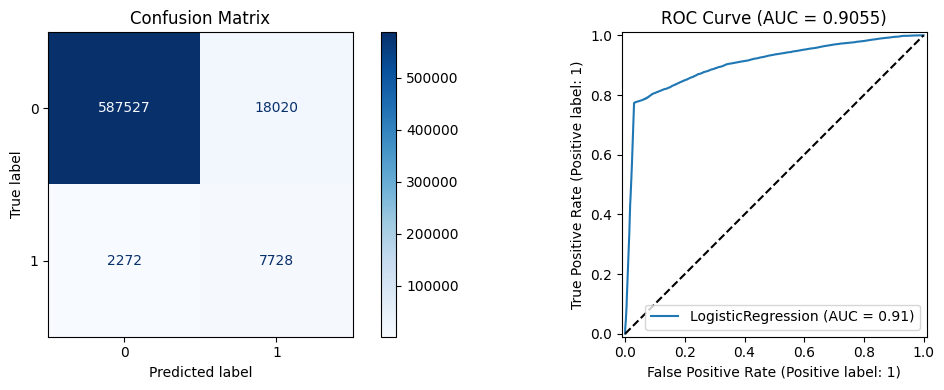

In [22]:
# Visualization: Confusion Matrix and ROC Curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')

# ROC Curve - use the display's computed AUC for consistency
roc_display = RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_title(f'ROC Curve (AUC = {roc_display.roc_auc:.4f})')  # Use display's AUC

plt.tight_layout()
plt.show()

---

## 10. Save Artifacts

In [21]:
# Save cleaned data
df.to_parquet('cleaned_full.parquet', index=False)
print("Saved: cleaned_full.parquet")

# Save model
joblib.dump({'model': model, 'scaler': scaler}, f'artifacts/baseline_model_seed{SEED}.pkl')
print(f"Saved: artifacts/baseline_model_seed{SEED}.pkl")

# Generate integrity report
report = f"""# Data Integrity Report

Generated: {datetime.now().isoformat()}

## Summary
- Total rows: {len(df):,}
- Duplicates removed: {dup_full:,}

## Baseline Model
- Features: {feature_cols}
- ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}
- F1: {f1_score(y_test, y_pred):.4f}
"""

print(report)

print("\n" + "="*50)
print("NOTEBOOK 01 COMPLETE")
print("="*50)

Saved: cleaned_full.parquet
Saved: artifacts/baseline_model_seed42.pkl
# Data Integrity Report

Generated: 2026-01-15T17:04:46.065052

## Summary
- Total rows: 3,092,351
- Duplicates removed: 0

## Baseline Model
- Features: ['subject_age', 'subject_race_enc', 'subject_sex_enc', 'type_enc', 'search_conducted', 'frisk_performed']
- ROC-AUC: 0.9055
- F1: 0.4324


NOTEBOOK 01 COMPLETE
